In [1]:
import sys
import os

# Go up to project root, then into util
util_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'util'))
print("Adding to sys.path:", util_path)

if util_path not in sys.path:
    sys.path.append(util_path)



Adding to sys.path: c:\Users\Kirsingh\OneDrive - Advanced Micro Devices Inc\Desktop\ScreenWhisper\util


In [53]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from IPython.display import Image, display
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from typing import Annotated
from computer_tools import click_at, scroll, type_text_at, wait
import pyautogui
import torch
from ultralytics import YOLO
from PIL import Image
import importlib
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Goes up one level from current directory
sys.path.append(parent_dir)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
load_dotenv()

True

In [54]:
qwen = ChatGroq(
    model="qwen-qwq-32b",
    temperature=0,
)

In [ ]:
gemma = ChatGoogleGenerativeAI(model="gemini-1.5-flash",  temperature=0)

# **<u>Graph State</u>**

In [55]:
class State(MessagesState):
    query: str

# **<u>Binding Tools</u>**

In [167]:
llm_with_tools = qwen.bind_tools(tools=[click_at, scroll, type_text_at, wait])

# **<u>Computer Use</u>**

In [6]:
from PIL import Image

In [ ]:
device = 'cuda'
model_path=r"weights\icon_detect\model_v1_5.pt"
som_model = get_yolo_model(model_path)
#som_model.to(device)
print('model to {}'.format(device))


caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path=r"weights\icon_caption_florence")

model to cuda


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [158]:
def cua(state):
    print("----------------CUA START------------------")
    

    input_prompt = cua_prompt.invoke({"task": state["query"]})
    result = llm_with_tools.invoke(input_prompt)

    return {"messages": result}
    

    

In [9]:
def cua(state):
    print("----------------CUA START------------------")

    image = pyautogui.screenshot("screen.jpg")


    image_path = "screen.jpg"
    image = Image.open(image_path)
    image_rgb = image.convert('RGB')
    print('image size:', image.size)

    box_overlay_ratio = max(image.size) / 3200
    draw_bbox_config = {
        'text_scale': 0.8 * box_overlay_ratio,
        'text_thickness': max(int(2 * box_overlay_ratio), 1),
        'text_padding': max(int(3 * box_overlay_ratio), 1),
        'thickness': max(int(3 * box_overlay_ratio), 1),
    }
    BOX_TRESHOLD = 0.05

    import time
    start = time.time()
    ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
    text, ocr_bbox = ocr_bbox_rslt
    cur_time_ocr = time.time() 

    dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
    cur_time_caption = time.time() 
    
    screen_width = 1920
    screen_height = 1200

    center_coords_and_content_str = "\n".join(
        f"Content: {item['content']} | Center: ({int((item['bbox'][0] + item['bbox'][2]) / 2 * screen_width)}, {int((item['bbox'][1] + item['bbox'][3]) / 2 * screen_height)})"
        for item in parsed_content_list
    )

    print(center_coords_and_content_str)


    input_prompt = cua_prompt.invoke({"task": state["query"], "screen_state": center_coords_and_content_str})
    result = llm_with_tools.invoke(input_prompt)

    return {"messages": result}
    

    

# **<u>Router</u>**

In [151]:
def router(state):
    print("------------------router-------------------")

    messages = state["messages"]
    print("messages in router", messages)
    last_message = messages[-1]
    print("last messages", last_message)
    if last_message.tool_calls:
        return "tools"
    return END

In [160]:
tools=[click_at, type_text_at, wait]

# **<u>Graph Builder</u>**

In [161]:
builder = StateGraph(State)

# **<u>Nodes</u>**

In [162]:
builder.add_node("cua", cua)
builder.add_node("tools", ToolNode(tools=tools))


# **<u>Edges</u>**

In [163]:
builder.add_edge(START, "cua")
builder.add_conditional_edges("cua", router)
builder.add_edge("tools", "cua")


# **<u>Graph</u>**

In [122]:
from langgraph.checkpoint.memory import MemorySaver

In [123]:
memory = MemorySaver()

In [164]:
graph = builder.compile()

# **<u>Graph Plot</u>**

In [18]:
from PIL import Image

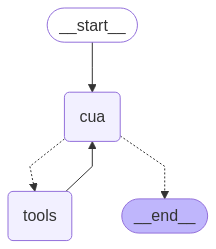

In [165]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [125]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
inputs = {"query":HumanMessage(content="open chrome")}
for chunk in graph.stream(inputs, stream_mode="values", config=config):
    print(chunk)